## PS2 Solution. Lepinskikh Alexander
### Task 1. Visualization
First of all, let's preprocess data and visualize it. Before we are going to realize rapidly-exploring random tree algorithm, we should explore data and understand it structure.

#### Task 1.1. First visualization
First of all, let's visualize the manipulator in the start_state and the goal_state. Also, we can explore enviroment with obstacles.

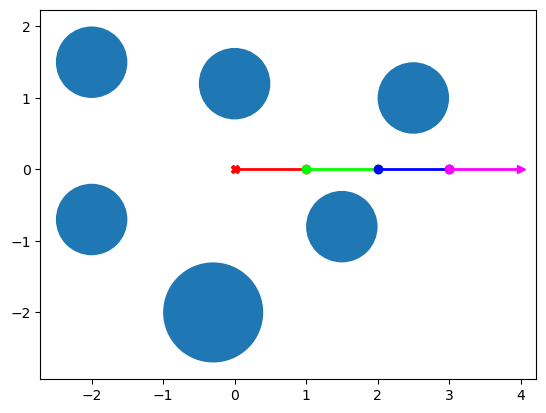

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from environment import State, ManipulatorEnv
from rrt import RRTPlanner
import matplotlib.animation as animation
from scipy import signal

with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)

start_state = State(np.array(data["start_state"]))
goal_state = State(np.array(data["goal_state"]))
env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                     initial_state=start_state,
                     collision_threshold=data["collision_threshold"])

env.render()

<module 'matplotlib.pyplot' from '/Users/qud/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

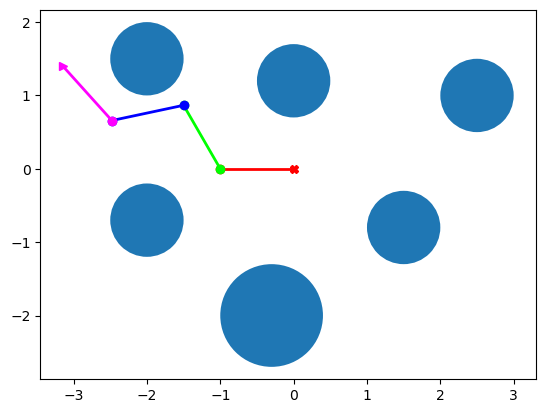

In [8]:
env.state = goal_state
env.render()

Comments: the main difference with the previous task is the fact that in PS1 we have discrete space which could be described as an integer grid, so we can work with it as a matrix, where i, j are integer coordinates on the grid. Now, we have continious space, so it could not be described with such similar method. Also, a star algorithm, which worked perfectly in discrete space could not be used in new case because of fact we can not describe our new space as a connected graph. 

#### Task 1.2. Manipulator states visualization
Let's visualize our manipulator in several different states. Some of them should collised with the obstacles, some of them should not.
First of all, let's try yo generate several radom states with np.random.rand().

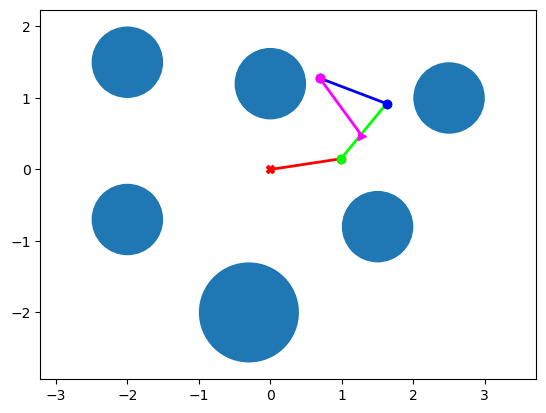

In [44]:
rand_state1 = State(np.random.rand(4) * 180)
env.state = rand_state1
env.render()

In [45]:
print(env.check_collision(rand_state1))

False


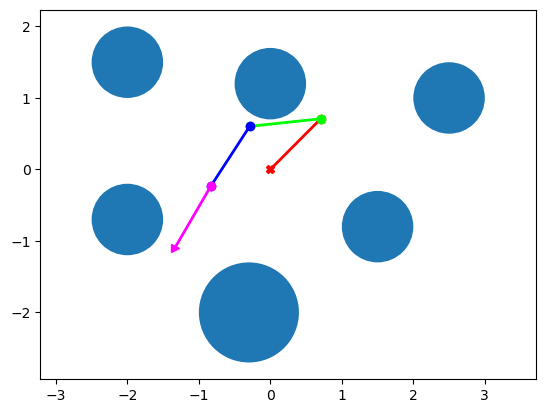

In [41]:
rand_state2 = State(np.random.rand(4) * 180)
env.state = rand_state2
env.render()

In [42]:
print(env.check_collision(rand_state2))

True


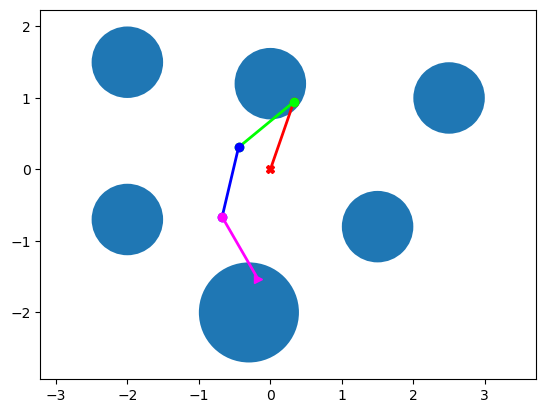

In [46]:
rand_state3 = State(np.random.rand(4) * 180)
env.state = rand_state3
env.render()

In [47]:
print(env.check_collision(rand_state3))

True


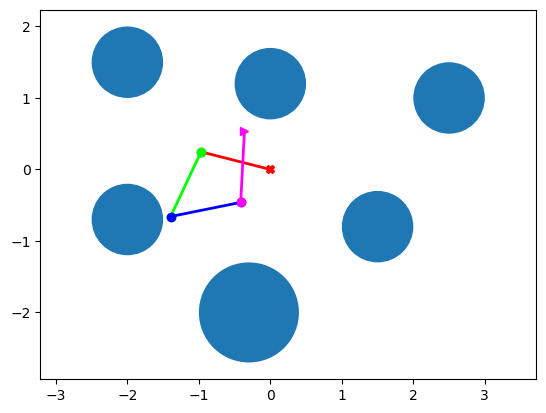

In [51]:
rand_state4 = State(np.random.rand(4) * 180)
env.state = rand_state4
env.renbder()

In [52]:
print(env.check_collision(rand_state4))

False


<Figure size 640x480 with 0 Axes>

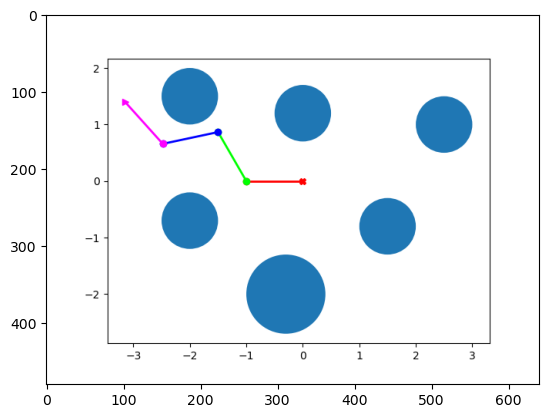

In [3]:




res = [start_state]
for i in range(15):
    res.append(State(np.random.rand(4) * 360 - np.ones(4) * 180))
res.append(goal_state)

imgs = []

for s in res:
    env.state = s
    f = env.environment_image()
    s, (width, height) = f.canvas.print_to_buffer()
    X = np.frombuffer(s, np.uint8).reshape((height, width, 4))
    plt.clf()
    imgs.append(X)


fig = plt.figure()
ims = []
for img in imgs:
    plot = plt.imshow(img)
    ims.append([plot])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True)

ani.save("boo.mp4")

plt.show()

Comments: we have generated four different states with np.random.rand(). The most inetersting one is second generated random state. Here, we can see that our manipulator does not cross obstacles on the map but we got check_collision() function True result. It is because our distance between obstacle and manipulator less than 0.1 collision distance. On the other states we can see several more common situations: if manipulator cross the obstacle we got True result, otherwise (if we have no intersection and distance more than 0.1) we have False. 

### Task 2. RRT Algorithm
In this task we are going to implement RRT algorithm to find some plan which transfer our manipulator from one state to another without obstacles intersection.


boo


<Figure size 640x480 with 0 Axes>

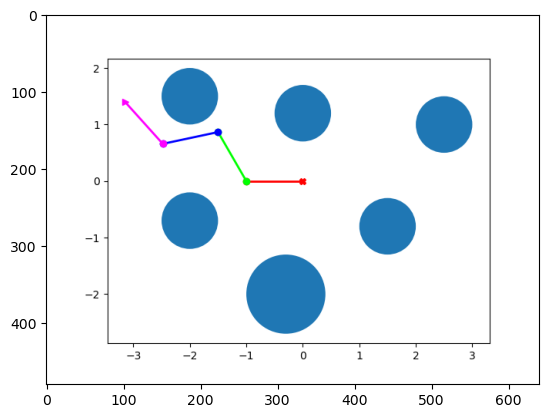

In [22]:
from angle_util import angle_difference, angle_linspace
from typing import List, Callable

ITERATION_NUMBER = 5000

class RRTPlanner:
    
    def __init__(self,
                 env: ManipulatorEnv,
                 distance_fn: Callable,
                 max_angle_step: float = 10.0):
        """
        :param env: manipulator environment
        :param distance_fn: function distance_fn(state1, state2) -> float
        :param max_angle_step: max allowed step for each joint in degrees
        """
        self._env = env
        self._distance_fn = distance_fn
        self._max_angle_step = max_angle_step

    def random_sample(self, goal_state:  State) -> State:
        k = np.random.rand() * 100
        if k < 15:
            return goal_state
        else:
            return State(np.random.rand(4) * 360 - np.ones(4) * 180)

    def nearest(self, state: State, tree: List[object]) -> State:
        distance_list = [L1(state, node[1]) for node in tree]
        return tree[min(range(len(distance_list)), key=distance_list.__getitem__)]

    def extend(self, state: State, random_state: State, step: float) -> State:
        rotation = angle_linspace(state.angles, random_state.angles, step)
        return State(rotation[1])

        

    def generate_random_node(self, tree: List[object], path: List[object], vertices, goal_state: State):
        point_with_collisions = True
        node_name = f"q{len(tree)}"

        random_state = self.random_sample(goal_state)
        parent = self.nearest(random_state, tree)
        node = self.extend(parent[1], random_state, 10)

        if self._env.check_collision(node):
            return

        if node in vertices:
            return
        vertices.add(node)
        tree.append([node_name, node, parent[0]])
        path.append([parent[1], node])

    def check_path(self, tree: List[object], path: List[object], goal_state: State) -> bool:
        if L1(goal_state, tree[-1][1]) < 10:
            path.append([tree[-1][1], goal_state])
            tree.append([f'q{len(tree)}', goal_state, tree[-1][0]])
            return True
        return False

    def plot(self, path: List[object], save_path: str = 'rod_solve.mp4'):
        imgs = []

        for s in path:
            self._env.state = s
            f = self._env.environment_image()
            s, (width, height) = f.canvas.print_to_buffer()
            X = np.frombuffer(s, np.uint8).reshape((height, width, 4))
            plt.clf()
            imgs.append(X)


        fig = plt.figure()
        ims = []
        for img in imgs:
            plot = plt.imshow(img)
            ims.append([plot])

        ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)

        ani.save(save_path)

        plt.show()
        

    def plan(self,
             start_state: State,
             goal_state: State) -> List[State]:
        tree = []
        tree.append(['q0', start_state, 'None'])
        path = []
        vertices = set()
        vertices.add(start_state)
        while True:
            self.generate_random_node(tree, path, vertices, goal_state)
            if self.check_path(tree, path, goal_state):
                break
        print('boo')
        path = create_path(path, start_state, goal_state)
        self.plot(path)


def create_path(path: List[object], start_state: State, goal_state: State):
    ind = len(path) - 1
    res = []
    current_state = goal_state
    while ind >= 0 and path[ind][0] != start_state:
        if path[ind][1] == current_state:
            res.append(current_state)
            current_state = path[ind][0]
        ind -= 1
    res.append(start_state)
    res.reverse()
    return res


def L1(q1: State,
       q2: State) -> float:
    """
    :param q1: first configuration of the robot
    :param q2: second configuration of the robot
    :return: L1 distance between two configurations
    """
    return np.sum(np.absolute(angle_difference(q1.angles, q2.angles)))


def find_closest(state: State, tree: List[object]) -> State:
    """
    :param state: find the closest state to random_state
    :return: state with the minimal distance
    """
    distance_list = [L1(state, node[1]) for node in tree]
    return min(range(len(distance_list)), key=distance_list.__getitem__)




            
planner = RRTPlanner(env, L1)

plan = planner.plan(start_state, goal_state)